# LunarLander

In [1]:
env_name = "LunarLander-v2"

In [ ]:
# install dependencies
!pip install swig==4.2.1 2>&1
!pip install gymnasium==0.29.1 2>&1
!pip install pettingzoo==1.24.3 2>&1
!pip install box2d-py==2.3.5 2>&1

In [2]:
# interact with env
import gymnasium as gym
env = gym.make(env_name)
observation, info = env.reset()
cum_reward = 0
for _ in range(10):
    action = env.action_space.sample()
    observation, reward, terminated, truncated, info = env.step(action)
    cum_reward += reward
    if terminated or truncated:
        observation, info = env.reset()

env.close()
print(f"cum_reward:{cum_reward}")

cum_reward:2.0108488379366865


## Train agent / Torch Q-Learning

In [3]:
model_path = "lunar_lander_q_model.pt"

In [4]:
import gymnasium as gym
import torch
import torch.nn as nn
import numpy as np
from collections import deque
import random
from typing import Tuple, List
import matplotlib.pyplot as plt
import os

class QNetwork(nn.Module):
    def __init__(self, input_size: int, output_size: int):
        super(QNetwork, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(input_size, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, output_size)
        )
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.network(x)

class ReplayBuffer:
    def __init__(self, capacity: int):
        self.buffer = deque(maxlen=capacity)
    
    def push(self, state: np.ndarray, action: int, reward: float, 
             next_state: np.ndarray, done: bool):
        self.buffer.append((state, action, reward, next_state, done))
    
    def sample(self, batch_size: int) -> Tuple:
        states, actions, rewards, next_states, dones = zip(*random.sample(self.buffer, batch_size))
        return (np.array(states), np.array(actions), np.array(rewards), 
                np.array(next_states), np.array(dones))
    
    def __len__(self) -> int:
        return len(self.buffer)

class LunarLanderAgent:
    def __init__(self, state_size: int, action_size: int):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.q_network = QNetwork(state_size, action_size).to(self.device)
        self.target_network = QNetwork(state_size, action_size).to(self.device)
        self.target_network.load_state_dict(self.q_network.state_dict())
        
        self.optimizer = torch.optim.Adam(self.q_network.parameters(), lr=5e-4)
        self.memory = ReplayBuffer(100000)
        
        self.batch_size = 64
        self.gamma = 0.99
        self.epsilon = 1.0
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995
        self.target_update = 10
        self.action_size = action_size
        
    def act(self, state: np.ndarray, training: bool = True) -> int:
        if training and random.random() < self.epsilon:
            return random.randrange(self.action_size)
        
        with torch.no_grad():
            state_tensor = torch.FloatTensor(state).unsqueeze(0).to(self.device)
            q_values = self.q_network(state_tensor)
            return q_values.argmax().item()
    
    def train(self, batch: Tuple):
        states, actions, rewards, next_states, dones = batch
        
        # Convert to tensors
        states = torch.FloatTensor(states).to(self.device)
        actions = torch.LongTensor(actions).to(self.device)
        rewards = torch.FloatTensor(rewards).to(self.device)
        next_states = torch.FloatTensor(next_states).to(self.device)
        dones = torch.FloatTensor(dones).to(self.device)
        
        # Current Q values
        current_q_values = self.q_network(states).gather(1, actions.unsqueeze(1))
        
        # Next Q values
        with torch.no_grad():
            next_q_values = self.target_network(next_states).max(1)[0]
            target_q_values = rewards + (1 - dones) * self.gamma * next_q_values
        
        # Compute loss and update
        loss = nn.MSELoss()(current_q_values.squeeze(), target_q_values)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
        # Update epsilon
        self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)
        
        return loss.item()

    def save_model(self, path: str):
        """Save the trained Q-network"""
        torch.save({
            'q_network_state_dict': self.q_network.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict(),
            'epsilon': self.epsilon
        }, path)


In [5]:
def train_agent(episodes: int = 1000, render: bool = False) -> Tuple[List[float], List[float]]:
    env = gym.make(env_name)
    state_size = env.observation_space.shape[0]
    action_size = env.action_space.n
    
    agent = LunarLanderAgent(state_size, action_size)
    rewards_history = []
    losses_history = []
    
    for episode in range(episodes):
        state, _ = env.reset()
        episode_reward = 0
        episode_losses = []
        
        while True:
            if render and episode % 50 == 0:
                env.render()
            
            action = agent.act(state)
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            
            agent.memory.push(state, action, reward, next_state, done)
            episode_reward += reward
            
            if len(agent.memory) > agent.batch_size:
                batch = agent.memory.sample(agent.batch_size)
                loss = agent.train(batch)
                episode_losses.append(loss)
            
            if done:
                break
                
            state = next_state
        
        # Update target network
        if episode % agent.target_update == 0:
            agent.target_network.load_state_dict(agent.q_network.state_dict())
        
        rewards_history.append(episode_reward)
        losses_history.append(np.mean(episode_losses) if episode_losses else 0)
        
        if episode % 10 == 0:
            avg_reward = np.mean(rewards_history[-10:])
            print(f"Episode {episode}, Average Reward: {avg_reward:.2f}, Epsilon: {agent.epsilon:.2f}")
    
    env.close()
    agent.save_model(model_path)
    
    print(f"Model saved to {model_path}")
    return rewards_history, losses_history
def plot_training_results(rewards: List[float], losses: List[float]):
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.plot(rewards)
    plt.title('Episode Rewards')
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    
    plt.subplot(1, 2, 2)
    plt.plot(losses)
    plt.title('Training Losses')
    plt.xlabel('Episode')
    plt.ylabel('Loss')
    
    plt.tight_layout()
    plt.show()

In [6]:
rewards, losses = train_agent(episodes=50)

Episode 0, Average Reward: -151.33, Epsilon: 0.88
Episode 10, Average Reward: -404.25, Epsilon: 0.01
Episode 20, Average Reward: -163.89, Epsilon: 0.01
Episode 30, Average Reward: -182.47, Epsilon: 0.01
Episode 40, Average Reward: -187.44, Epsilon: 0.01
Model saved to lunar_lander_q_model.pt


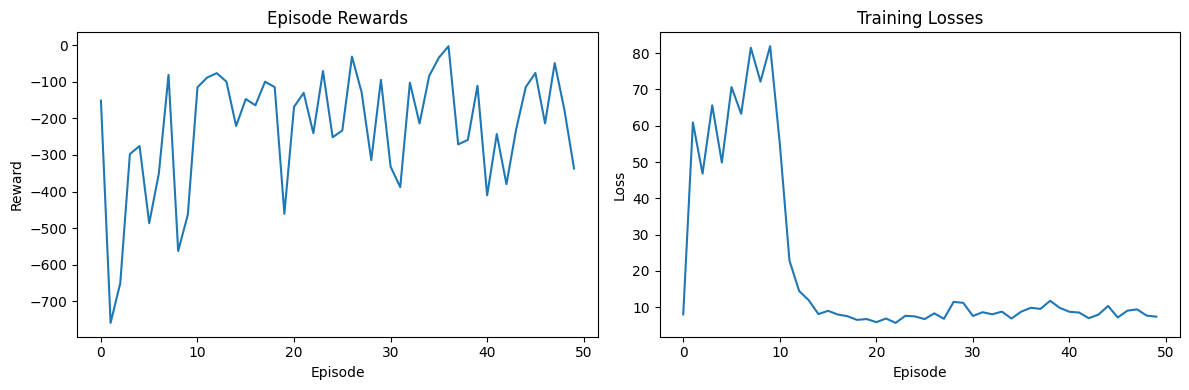

In [7]:
plot_training_results(rewards, losses)

## Publish agent

#### Go to https://ml-arena.com/viewcompetition/1 , join Competition and add your `lunar_lander_q_model.pt` file and use `agent.py` bellow. Choose Torch Runtime and Deploy!

In [1]:
class Agent:
    """Standardized agent interface for the platform"""
    def __init__(self, env):
        self.env = env
        
        # Initialize the Q-network
        state_size = env.observation_space.shape[0]
        action_size = env.action_space.n
        self.q_network = QNetwork(state_size, action_size)
        
        # Load the trained model
        model_path = "lunar_lander_q_model.pt"
        self.load_model(model_path)
        
        # Set to evaluation mode
        self.q_network.eval()

    def load_model(self, model_path: str):
        """Load the trained model parameters"""
        if not os.path.exists(model_path):
            raise FileNotFoundError(f"No model file found at {model_path}")
            
        checkpoint = torch.load(model_path)
        self.q_network.load_state_dict(checkpoint['q_network_state_dict'])

    def choose_action(self, observation, reward=0.0, terminated=False, truncated=False, info=None, action_mask=None):
        """Select action based on current observation"""
        with torch.no_grad():
            # Convert observation to tensor
            state_tensor = torch.FloatTensor(observation).unsqueeze(0)
            
            # Get Q-values and select best action
            q_values = self.q_network(state_tensor)
            return q_values.argmax().item()